# mRS distribution derivation, step-by-step

Because Anna has become muddled once again

In [1]:
import numpy as np
import matplotlib.pyplot as plt

![](./images/excess_deaths_mt.png)

In [2]:
mrs_dists = dict()
mrs_dists['pre_stroke_lvo'] = np.array([0.4179, 0.1430, 0.1184, 0.1642, 0.1138, 0.0427, 0.0000])
mrs_dists['no_treatment_lvo'] = np.array([0.0500, 0.0790, 0.1360, 0.1640, 0.2470, 0.1350, 0.1890])

In [3]:
mrs_dists_cumsum = dict()
for key, val in zip(mrs_dists.keys(), mrs_dists.values()):
    mrs_dists_cumsum[key] = np.cumsum(mrs_dists[key])

In [4]:
mrs_dists_cumsum

{'pre_stroke_lvo': array([0.4179, 0.5609, 0.6793, 0.8435, 0.9573, 1.    , 1.    ]),
 'no_treatment_lvo': array([0.05 , 0.129, 0.265, 0.429, 0.676, 0.811, 1.   ])}

In [5]:
def convert_prob_to_logodds(p):
    return np.log(p / (1.0 - p))

In [6]:
def convert_logodds_to_prob(l):
    return np.exp(l) / (1.0 + np.exp(l))

In [ ]:
# Probabilities in pre-stroke and no-treatment dists:
# P(mRS < 6)
p_pre = mrs_dists_cumsum['pre_stroke_lvo'][5]
p_not = mrs_dists_cumsum['no_treatment_lvo'][5]

# Target probability at average MT treatment time:
p_death_mt = 97.0 / 633.0
p_target = 1.0 - p_death_mt
l_target = convert_prob_to_logodds(p_target)

# Times in hours:
t0 = 0.0
tne = 8.0
# Average MT treatment time:
t_target = (285.0 / 60.0)

In [ ]:
p_pre, p_not, p_target

In [ ]:
convert_logodds_to_prob(l_target)

## When excess deaths are zero, what is the mortality rate at 285 minutes?

In [ ]:
def calculate_logodds_with_excess_deaths(p_pre, p_not, ed):
    # Weight pre-stroke probability by excess deaths:
    p_pre_deaths = p_pre * (1.0 - ed)
    # Weight no-treatment probability by excess deaths:
    p_tne = p_not * (1.0 - ed)
    # Calculate new time-zero-treatment probability by
    # combining the new pre-stroke and no-treatment probs:
    p_t0 = 0.75 * p_pre_deaths + 0.25 * p_tne
    
    # Convert time-zero and time-of-no-effect probs to logodds:
    l_t0 = convert_prob_to_logodds(p_t0)
    l_tne = convert_prob_to_logodds(p_tne)
    return l_t0, l_tne

In [ ]:
def calculate_logodds_t_target(ed, p_pre, p_not, tne, t0, t_target):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)

    slope = (l_tne - l_t0) / (tne - t0)
    y_intercept = l_t0

    l_t_target = slope * t_target + y_intercept
    return l_t_target

In [ ]:
l_target_ed0 = calculate_logodds_t_target(0.0, p_pre, p_not, tne, t0, t_target)
p_target_ed0 = convert_logodds_to_prob(l_target_ed0)

print(f'Mortality at {t_target} hours: {1.0 - p_target_ed0:.2%}')

## Try various excess death rates

In [ ]:
plt.scatter(t_target, l_target, label='Target', marker='x')
for ed in np.arange(0.00, 0.10, 0.02):
    # Find endpoints of the straight line for this excess deaths value:
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    # Plot the straight line fit:
    plt.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths'
    )
plt.legend()
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.show()

## Optimize the value of "excess deaths"

In [ ]:
def calculate_difference_logodds_t_target(ed, args):
    l_t_target = calculate_logodds_t_target(ed, *args[1:])
    return np.abs(args[0] - l_t_target)

In [ ]:
from scipy.optimize import minimize

In [ ]:
results = minimize(
    calculate_difference_logodds_t_target,  # Result from this func.
    0.03,                                    # Initial guess.
    # args = [p_pre, p_not, tne, t0, t_target],  # Constants.
    args = [l_target, p_pre, p_not, tne, t0, t_target],  # Constants.
    method='Nelder-Mead'                    # Good when abs() in func.
)

# Save the optimized excess deaths value:
ed_opt = results.x[0]

# View full results:
results

Check that this value is sensible by plotting its straight line fit:

In [ ]:
plt.scatter(t_target, l_target, label='Target', marker='x')

l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed_opt)
plt.plot(
    [t0, tne],
    [l_t0, l_tne],
    label=f'{ed_opt:.2%} excess deaths'
)

# l_t_target_opt = calculate_logodds_t_target(ed_opt)
# plt.scatter(t_target, l_t_target_opt, marker='x', color='k')
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.legend()
plt.show()

# Flip the probabilities

This method doesn't seem to work properly - get 36% excess deaths. Think it's because the mRS=6 bin is zero in the pre-stroke distribution, so scaling it up keeps the zero value when it ought to become non-zero deaths.

In [25]:
# Probabilities in pre-stroke and no-treatment dists:
# P(mRS < 6)
p_death_pre = mrs_dists['pre_stroke_lvo'][-1]
p_death_not = mrs_dists['no_treatment_lvo'][-1]

# Target probability at average MT treatment time:
p_death_mt = 97.0 / 633.0
l_death_target = convert_prob_to_logodds(p_death_mt)

# Times in hours:
t0 = 0.0
tne = 8.0
# Average MT treatment time:
t_target = (285.0 / 60.0)

In [22]:
print(p_death_pre, p_death_not, p_death_mt)

0.0 0.189 0.15323854660347552


In [9]:
p_death_pre * (1.00 + 0.02)

0.0

In [10]:
p_death_not * (1.00 + 0.02)

0.19278

In [11]:
p_death_mt

0.15323854660347552

In [12]:
l_death_target

-1.709423182567419

## When excess deaths are zero, what is the mortality rate at 285 minutes?

In [13]:
def calculate_logodds_with_excess_deaths(p_pre, p_not, ed):
    # Weight pre-stroke probability by excess deaths:
    p_pre_deaths = p_pre * (1.0 + ed)
    # Weight no-treatment probability by excess deaths:
    p_tne = p_not * (1.0 + ed)
    # Calculate new time-zero-treatment probability by
    # combining the new pre-stroke and no-treatment probs:
    p_t0 = 0.75 * p_pre_deaths + 0.25 * p_tne
    
    # Convert time-zero and time-of-no-effect probs to logodds:
    l_t0 = convert_prob_to_logodds(p_t0)
    l_tne = convert_prob_to_logodds(p_tne)
    return l_t0, l_tne

In [14]:
def calculate_logodds_t_target(ed, p_pre, p_not, tne, t0, t_target):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)

    slope = (l_tne - l_t0) / (tne - t0)
    y_intercept = l_t0

    l_t_target = slope * t_target + y_intercept
    return l_t_target

In [27]:
l_death_t0, l_death_tne = calculate_logodds_with_excess_deaths(p_death_pre, p_death_not, ed=0.0)

print(l_death_t0, l_death_tne)

-3.0038998858142176 -1.4565210390557706


In [23]:
l_death_target_ed0 = calculate_logodds_t_target(0.0, p_death_pre, p_death_not, tne, t0, t_target)
p_death_target_ed0 = convert_logodds_to_prob(l_death_target_ed0)

print(f'Mortality at {t_target} hours: {p_death_target_ed0:.2%}')

Mortality at 4.75 hours: 11.05%


In [26]:
l_death_target_ed0

-2.08514369555139

## Try various excess death rates

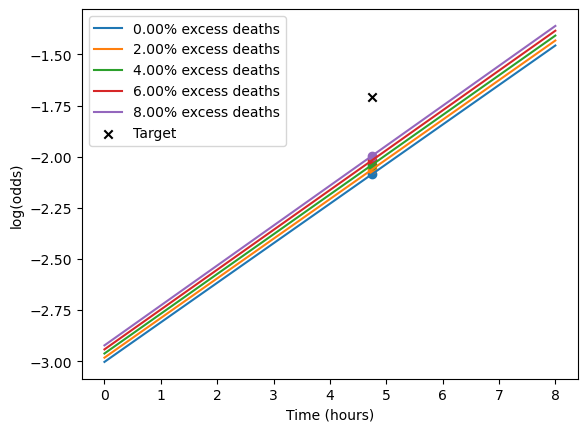

In [30]:
for ed in np.arange(0.00, 0.10, 0.02):
    # Find endpoints of the straight line for this excess deaths value:
    # l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    l_death_t0, l_death_tne = calculate_logodds_with_excess_deaths(p_death_pre, p_death_not, ed)
    # Plot the straight line fit:
    plt.plot(
        [t0, tne],
        [l_death_t0, l_death_tne],
        label=f'{ed:.2%} excess deaths'
    )
    
    l_death_target_ed = calculate_logodds_t_target(ed, p_death_pre, p_death_not, tne, t0, t_target)
    plt.scatter(t_target, l_death_target_ed)

plt.scatter(t_target, l_death_target, label='Target', marker='x', color='k')
plt.legend()
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.show()

## Optimize the value of "excess deaths"

In [17]:
def calculate_difference_logodds_t_target(ed, args):
    l_t_target = calculate_logodds_t_target(ed, *args[1:])
    return np.abs(args[0] - l_t_target)

In [18]:
from scipy.optimize import minimize

In [19]:
results = minimize(
    calculate_difference_logodds_t_target,  # Result from this func.
    0.03,                                    # Initial guess.
    args = [l_death_target, p_death_pre, p_death_not, tne, t0, t_target],  # Constants.
    method='Nelder-Mead'                    # Good when abs() in func.
)

# Save the optimized excess deaths value:
ed_opt = results.x[0]

# View full results:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3232797258844187e-05
             x: [ 3.698e-01]
           nit: 19
          nfev: 38
 final_simplex: (array([[ 3.698e-01],
                       [ 3.698e-01]]), array([ 1.323e-05,  7.133e-05]))

Check that this value is sensible by plotting its straight line fit:

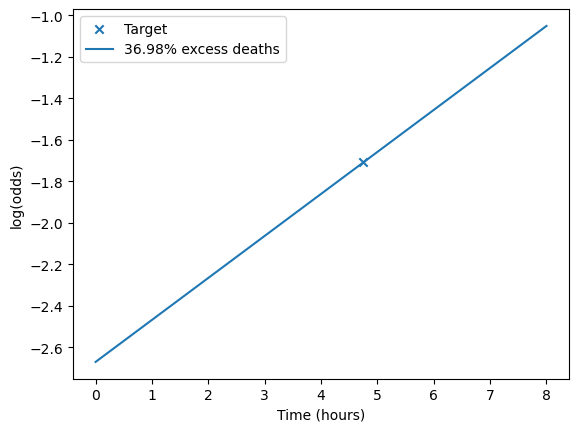

In [20]:
plt.scatter(t_target, l_death_target, label='Target', marker='x')

l_death_t0, l_death_tne = calculate_logodds_with_excess_deaths(p_death_pre, p_death_not, ed_opt)
plt.plot(
    [t0, tne],
    [l_death_t0, l_death_tne],
    label=f'{ed_opt:.2%} excess deaths'
)

# l_t_target_opt = calculate_logodds_t_target(ed_opt)
# plt.scatter(t_target, l_t_target_opt, marker='x', color='k')
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.legend()
plt.show()

In [21]:
convert_logodds_to_prob(l_death_target)

0.15323854660347552